In [1]:
import numpy as np
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers

## Create Simulated Data

In [2]:
def create_data(n=100):
    """
        f(x1, x2) = 5 * x_1**2 + 4 * x_2**2 - 3 * x_1 * x_2
    """
    ret = np.zeros(shape=(n, 3)).astype("float32")
    x = np.random.rand(n, 2)
    y = (5 * x[:, 0]**2 + 4 * x[:, 1]**2 - 3 * x[:, 0] * x[:, 1]).reshape(-1, 1)
    ret[:, [0, 1]] = x
    ret[:, [2]] = y
    
    return ret

## Test Out Function

In [3]:
d = create_data(4)

In [4]:
d

array([[0.84784013, 0.24306777, 3.2122445 ],
       [0.20672081, 0.962418  , 3.3218057 ],
       [0.78372735, 0.2650193 , 2.728975  ],
       [0.33390683, 0.70534396, 1.8409517 ]], dtype=float32)

In [5]:
val = round(5 * d[0, 0]**2 + 4 * d[0, 1]**2 - 3 * d[0, 0] * d[0, 1], 4)
exp_val = round(d[0, 2], 4)

val, exp_val

(3.2122, 3.2122)

## Create Network

The network that we will create will have two dense layers with ReLU activations. The goal is to see how many of these neurons become "dead".

### Train and Test Data

In [6]:
NUM_SAMPLES = 1000
TRAIN_FRAC = 0.60
VAL_FRAC = 0.20

data = create_data(n=1000)

train_idx = int(TRAIN_FRAC * NUM_SAMPLES)
val_idx = train_idx + int(VAL_FRAC * NUM_SAMPLES)

train_data = data[: train_idx]
val_data = data[train_idx: val_idx]
test_data = data[val_idx: ]

### Normalizer 

In [7]:
def normalize(data: np.array, mean: np.array=None, sd: np.array=None):
    if (mean is not None) and (sd is not None):
        assert data.shape[1] == len(mean) == len(sd)
    
    if mean is None:
        mean = data.mean(axis=0)
    if sd is None:
        sd = data.std(axis=0)
    
    normed = (data - mean) / sd
    
    return mean, sd, normed

In [8]:
mean, sd, norm_train_data = normalize(train_data)
_, _, norm_val_data = normalize(val_data, mean=mean, sd=sd)
_, _, norm_test_data = normalize(test_data, mean=mean, sd=sd)

### Model Layers

In [9]:
inputs = keras.Input(shape=2)

dense_1 = layers.Dense(units=10, activation='relu')(inputs)
#leaky_1 = tf.keras.layers.LeakyReLU(dense_1)

dense_2 = layers.Dense(units=10, activation='relu')(dense_1)
#leaky_2 = tf.keras.layers.LeakyReLU(dense_2) 

output = layers.Dense(units=1, activation=None)(dense_2)

In [10]:
model = keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback


checkpoint_filepath = './checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

weights_dict = {}

weight_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: weights_dict.update({epoch: model.get_weights()})
)

In [13]:
BATCH_SIZE = 32
EPOCHS = 10

train_dataset = tf.data.Dataset.from_tensor_slices((test_data[:, [0, 1]], 
                                                    test_data[:, [2]])).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data[:, [0, 1]], 
                                                  val_data[:, [2]])).batch(BATCH_SIZE)

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=val_dataset, 
                    callbacks=[weight_callback])

Epoch 1/10
7/7 [==============================] - 1s 42ms/step - loss: 6.8410 - val_loss: 6.3297
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 6.2533 - val_loss: 5.9366
Epoch 3/10
7/7 [==============================] - 0s 4ms/step - loss: 5.8660 - val_loss: 5.6089
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 5.5362 - val_loss: 5.3118
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 5.2367 - val_loss: 5.0335
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 4.9544 - val_loss: 4.7599
Epoch 7/10
7/7 [==============================] - 0s 4ms/step - loss: 4.6792 - val_loss: 4.4927
Epoch 8/10
7/7 [==============================] - 0s 5ms/step - loss: 4.4093 - val_loss: 4.2279
Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 4.1429 - val_loss: 3.9688
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 3.8821 - val_loss: 3.7162


In [14]:
pred = model.predict(test_data[:, [0, 1]])

In [15]:
np.mean((pred - test_data[:, [2]])**2)

3.8280993

## Evolution of Weights by Epoch

In [16]:
weights_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
weights_dict[0]

[array([[ 0.346244  , -0.16914655,  0.63169885,  0.19244133,  0.6787307 ,
          0.5277619 ,  0.26484022, -0.24665481, -0.59585655, -0.19254394],
        [-0.4132985 ,  0.34158713,  0.5036465 ,  0.17870177, -0.02432844,
         -0.17700672, -0.02039643, -0.30802688,  0.6190297 ,  0.07982939]],
       dtype=float32),
 array([ 0.01201973, -0.01378957, -0.0044037 ,  0.01370485,  0.0128527 ,
         0.01343565, -0.01310289,  0.        , -0.0072619 ,  0.00664367],
       dtype=float32),
 array([[-0.11089499,  0.5180531 ,  0.03790708, -0.1986907 , -0.15093157,
          0.52155423, -0.41691464,  0.32344282, -0.0941834 ,  0.03487526],
        [ 0.1977741 , -0.18900082, -0.31867653,  0.24186066,  0.37462312,
         -0.29742032, -0.05717823, -0.4646392 ,  0.46465996,  0.31972638],
        [-0.55840075,  0.50354207,  0.0964688 , -0.12036184, -0.04115963,
          0.2373951 , -0.27409476, -0.55378234, -0.21600224,  0.32892013],
        [ 0.25675058, -0.28670582,  0.16294987, -0.2864608 , 

In [18]:
# these are the weights from the input x1 to the the 10 neurons in the first layer
weights_dict[0][0][0]

array([ 0.346244  , -0.16914655,  0.63169885,  0.19244133,  0.6787307 ,
        0.5277619 ,  0.26484022, -0.24665481, -0.59585655, -0.19254394],
      dtype=float32)

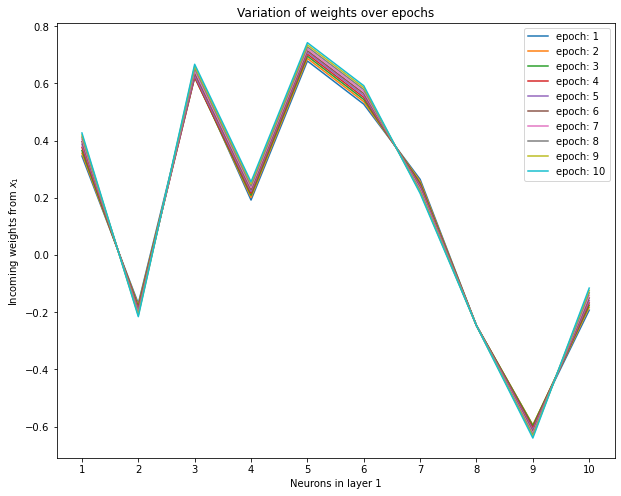

In [19]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
x_vals = range(1, 10 + 1)

for epoch in range(0, EPOCHS):
    weights = weights_dict[epoch][0][0]
    ax.plot(x_vals, weights, label=f'epoch: {epoch + 1}')

ax.set_title('Variation of weights over epochs')
ax.set_xticks(range(1, 11))
ax.set_xlabel('Neurons in layer 1')
ax.set_ylabel(r'Incoming weights from $x_1$')
plt.legend();

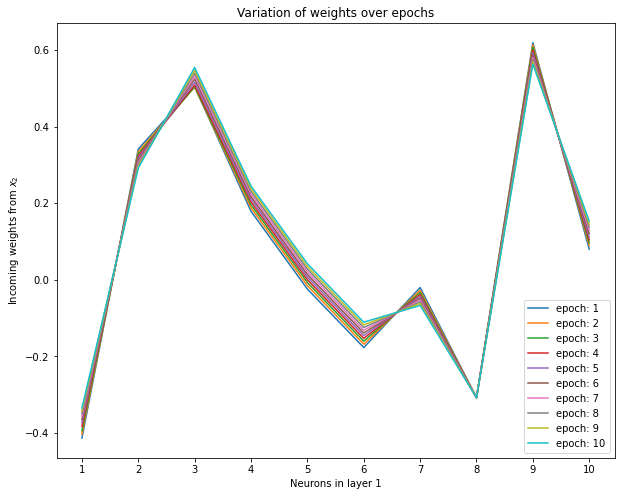

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
x_vals = range(1, 10 + 1)

for epoch in range(0, EPOCHS):
    weights = weights_dict[epoch][0][1]
    ax.plot(x_vals, weights, label=f'epoch: {epoch + 1}')
    
ax.set_title('Variation of weights over epochs')
ax.set_xticks(range(1, 11))
ax.set_xlabel('Neurons in layer 1')
ax.set_ylabel(r'Incoming weights from $x_2$')
plt.legend();

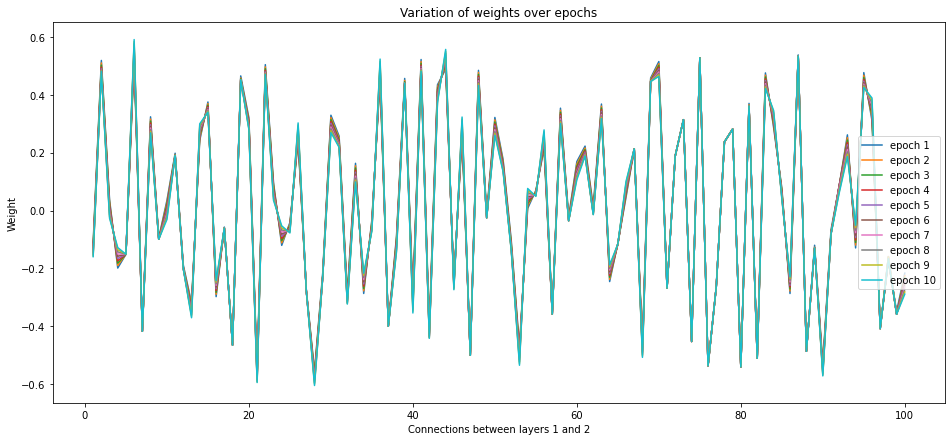

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
x_vals = range(1, 100 + 1)

for epoch in range(0, EPOCHS):
    weights = weights_dict[epoch][2].flatten()
    ax.plot(x_vals, weights, label=f'epoch {epoch + 1}')
    

ax.set_title('Variation of weights over epochs')
ax.set_xlabel('Connections between layers 1 and 2')
ax.set_ylabel('Weight')
plt.legend();